In [3]:
# DATA = '/Users/amee/Library/CloudStorage/GoogleDrive-ameeassad@gmail.com/My Drive/wildlife-datasets-main/data/BirdIndividualID'
DATA = 'data/BirdIndividualID_small'

In [4]:
import os

# Replace this with the path to the folder you want to check
folder_path = os.path.join(DATA, 'Original_pictures', 'IndividualID', 'great_tits', 'Test', '0110178201')

# Check if the folder exists and list its contents
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    print("The folder exists. Listing its contents:")
    for item in os.listdir(folder_path):
        print(item)
else:
    print("The folder does not exist or is not accessible.")


The folder exists. Listing its contents:
0110178201_2019-08-27_16-48-28.jpg
0110178201_2019-08-27_16-40-11.jpg


In [5]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
from wildlife_datasets import datasets, analysis, loader, metrics


In [7]:
d = datasets.BirdIndividualID('data/BirdIndividualID_small')
d.df

,image_id,identity,path,species,original_split
0,00176735596812d5,0110176514,Original_pictures/IndividualID/great_tits/Test...,great_tits,test
1,00239fb5101d581c,0700EE16B2,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train
2,00265006a4e647bc,011016BE08,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train
3,002712aae706b8a7,unknown,Original_pictures/New_birds/great_tits/newbird...,great_tits,NaN
4,00392a41c0880340,011016BE08,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train
...,...,...,...,...,...
3371,ffcc92615252d288,unknown,Original_pictures/New_birds/great_tits/newbird...,great_tits,NaN
3372,ffdb03ca8c6de664,011016BDC9,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train
3373,ffe243034c7e749a,011016F8EC,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train
3374,fff793f04979b5ee,01103F65D2,Original_pictures/IndividualID/sociable_weaver...,sociable_weavers,train


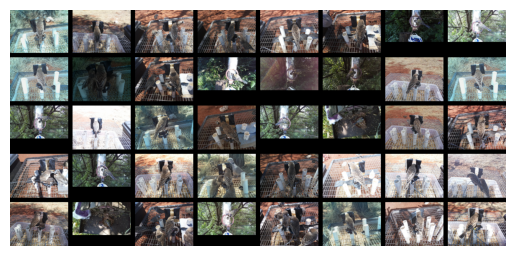

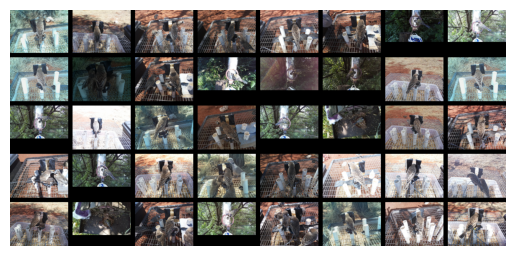

In [8]:
d.plot_grid()

Number of identitites            40
Number of all animals            3376
Number of animals with one image 0
Number of unidentified animals   501


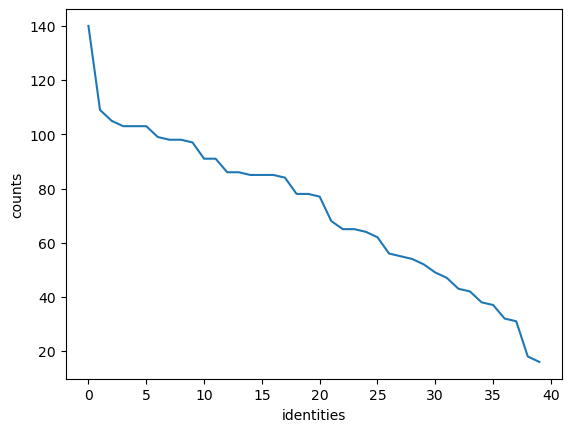

In [6]:
analysis.display_statistics(d.df, unknown_name= 'unknown')

In [7]:
print(d.root)
d.metadata

data/BirdIndividualID_small


{'url': 'https://github.com/AndreCFerreira/Bird_individualID',
 'cite': 'ferreira2020deep',
 'animals': {'great tit', 'sociable weaver'},
 'real_animals': True,
 'year': 2019,
 'reported_n_total': 3376.0,
 'reported_n_identified': 3376.0,
 'reported_n_photos': 3376.0,
 'reported_n_individuals': 40.0,
 'wild': False,
 'clear_photos': True,
 'pose': 'single',
 'unique_pattern': False,
 'from_video': False,
 'cropped': False,
 'span': '15 days',
 'size': 1530.0}

# Deep Features

In [11]:
import sys
sys.path.append('../wildlife-tools-main')
# sys.path.append('../wildlife-datasets-main')

In [21]:
import torch
print("torch version:", torch.__version__)

# Is MPS even available? macOS 12.3+
print("MPS available?", torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print("torch built with MPS?", torch.backends.mps.is_built())

device = torch.device('mps')

torch version: 2.1.2.post3
MPS available? True
torch built with MPS? True


In [22]:
import timm
import pandas as pd
import torchvision.transforms as T

from wildlife_tools.data import WildlifeDataset, SplitMetadata
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier

#### 1. Prepare `WildlifeDataset`
Using metadata from `wildlife-datasets`, create `WildlifeDataset` object for my dataset.

- Load metadata from pandas dataframe
- Create two datasets using split information from the metadata 
    - query - created from test split
    - database - created from train subset.

In [107]:
# metadata = pd.read_csv('ExampleDataset/metadata.csv')
metadata = d.df # create the a df from database directory

# image_root = 'ExampleDataset'
image_root = d.root

transform = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

dataset_database = WildlifeDataset(
    metadata = metadata, 
    root = image_root,
    split = SplitMetadata('original_split', 'train'),
    transform=transform
)

dataset_query = WildlifeDataset(
    metadata = metadata, 
    root = image_root,
    split = SplitMetadata('original_split', 'test'),
    transform=transform
)

# Optionally, split metadata into subsets. In this example, query is first 100 images and rest are in database.
# dataset_database = WildlifeDataset(metadata.df.iloc[100:,:], metadata.root, transform=transform)
# dataset_query = WildlifeDataset(metadata.df.iloc[:100,:], metadata.root, transform=transform)

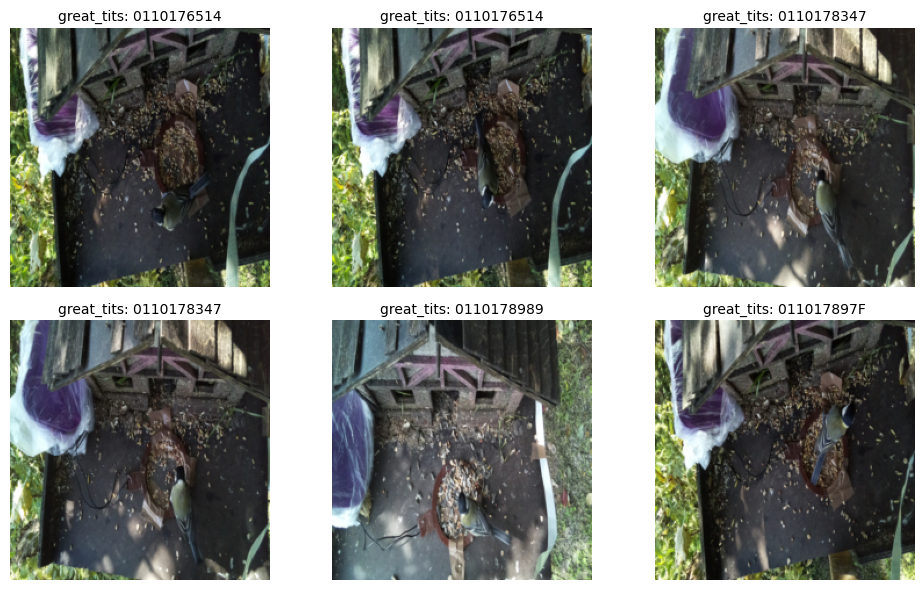

In [111]:
# EXAMPLE OF WHAT WE DO
from torchvision.transforms import Resize
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, (img, label) in enumerate(dataset_query):
    if i >= len(axes):
        break
    img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and transpose to (height, width, channels)
    
    # Denormalize the image for correct visualization
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{dataset_query.metadata.iloc[i]["species"]}: {dataset_query.labels_map[label]}", fontsize=10, pad=5)

plt.tight_layout()
plt.show()

In [33]:
img, label = dataset_database[102]
print(img.shape, label)

dataset_query

torch.Size([3, 224, 224]) 12


In [78]:
for key, value in dataset_query.__dict__.items():
    print(f'{key}: {value}')

split: <wildlife_tools.data.split.SplitMetadata object at 0x15fdcc470>
metadata:             image_id    identity  \
0   00176735596812d5  0110176514   
1   035c09dbbacf4df2  0110176514   
2   066013e5a275654c  0110178347   
3   06b5eff8029c6209  0110178347   
4   0a7d4599daa4b896  0110178989   
..               ...         ...   
89  f8c0233a4ac10e9e  01101787FB   
90  fc371565ced9badc  0110178201   
91  fdce61a32bdd0534  0110178989   
92  fdf7161bcd1757d3  0110178347   
93  fed3be9d8dbf109b  0110178989   

                                                 path     species  \
0   Original_pictures/IndividualID/great_tits/Test...  great_tits   
1   Original_pictures/IndividualID/great_tits/Test...  great_tits   
2   Original_pictures/IndividualID/great_tits/Test...  great_tits   
3   Original_pictures/IndividualID/great_tits/Test...  great_tits   
4   Original_pictures/IndividualID/great_tits/Test...  great_tits   
..                                                ...         ...   
89 

### 2. Extract features
Extract features using MegaDescriptor Tiny, downloaded from HuggingFace hub.

In [26]:
from wildlife_tools.features import DeepFeatures

backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)
extractor = DeepFeatures(backbone)
query, database = extractor(dataset_query), extractor(dataset_database)

print(f'Query features shape: {query.shape}, Database features shape: {database.shape}')

100%|███████████████████████████████████████████████████████████████| 19/19 [03:40<00:00, 11.58s/it]

Query features shape: (94, 768), Database features shape: (2336, 768)


### 3. Calculate similarity
- Calculate cosine similarity between query and database features.
    - Inputs are arrays with query and database features
    - Output is matrix with shape n_query x n_database.

- Use the similarity for KNN classifier
    - Output is array of n_query length.
    - Values in the array are nearest labels in the database. (with ordinal encoding - indexes of columns in the similarity matrix).

In [43]:
# Cosine similarity between deep features
similarity_function = CosineSimilarity()
similarity = similarity_function(query, database)['cosine']
print("Similarity matrix: \n", similarity.shape)

### Debug: Check indices and sizes
print(f"Database labels size: {len(dataset_database.labels_map)}")
print(f"Sample indices from similarity: {np.argmax(similarity, axis=1)[:10]}")
###

Similarity matrix: 
 (94, 2336)
Database labels size: 40
Sample indices from similarity: [2133 2062  217 2133  217  411 2096   14  767 2149]


### 4. Evaluate
Use the cosine similarity in nearest neigbour classifier and get predictions.

In [44]:
# Nearest neigbour classifier using the similarity
classifier = KnnClassifier(k=1, database_labels=dataset_database.labels)
preds = classifier(similarity)
preds = dataset_database.labels_map[preds]
print("Prediction \t", preds)
print("Ground truth \t", dataset_query.labels_string)

acc = sum(preds == dataset_query.labels_string) / len(dataset_query.labels_string)
print('\n Accuracy: ', acc)

Prediction 	 ['0110178989' '011017686F' '011017897F' '0110178989' '011017897F'
 '01101786C5' '0700EDAC58' '01101788B6' '0700EDDB4E' '01103F53DC'
 '0110178989' '011017897F' '0700EDAC58' '011017897F' '011017897F'
 '011017897F' '0110178989' '01101788B6' '011017897F' '011017897F'
 '011017897F' '011017897F' '0700EDAC58' '011017897F' '0110178989'
 '011017897F' '011017897F' '0700EDAC58' '011017897F' '011017897F'
 '011017897F' '0110178989' '011017897F' '01101786C5' '011017897F'
 '011017897F' '011017897F' '011017897F' '01101786C5' '01103F65D2'
 '011017897F' '0110178989' '0700EDAC58' '01101786C5' '01101788B6'
 '011017897F' '0110178989' '0700EE27D0' '011017897F' '01101788B6'
 '01101788B6' '0110178989' '0110178989' '01101786C5' '01101787FB'
 '01101788B6' '01101788B6' '011017897F' '0110178347' '01101786C5'
 '0110178989' '01101786C5' '011017897F' '0110178347' '011017897F'
 '0110178989' '01101786C5' '011017897F' '01101788B6' '01101786C5'
 '01101787FB' '011017897F' '011017897F' '0700EDDCC4' '01101786C

/Users/amee/Documents/code/wildlife/wildlife-datasets-main/../wildlife-tools-main/wildlife_tools/inference/classifier.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


### Visualisations

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# Function to load an image from a given path
def load_image(path):
    img_path = os.path.join(DATA, path)
    img = Image.open(img_path)
    return img

In [115]:
def display_results(query_metadata, db_metadata, query_start, predictions, num_images=10):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))
    fig.tight_layout(pad=0.5)
    
    for i in range(num_images):
        idx = query_start + i
        
        # Query image
        query_img_path = query_metadata.iloc[idx]['path']
        query_img = load_image(query_img_path)
        
        # Predicted image
        predicted_label = predictions[i]
        filtered_id_pred = db_metadata[db_metadata['identity'] == predicted_label]

        predicted_img_path = filtered_id_pred['path'].values[0]
        predicted_img_species = filtered_id_pred['species'].values[0]
        predicted_img = load_image(predicted_img_path)
        
        # Ground truth image
        ground_truth_label = query_metadata.iloc[idx]['identity'] # identity of the query image
        filtered_id_truth = db_metadata[db_metadata['identity'] == ground_truth_label] # get that from db

        ground_truth_img_path = filtered_id_truth['path'].values[0]
        truth_img_species = filtered_id_truth['species'].values[0]
        ground_truth_img = load_image(ground_truth_img_path)
        
        # Display query image
        axes[i, 0].imshow(query_img)
        axes[i, 0].set_title(f'Query Image: {query_metadata.iloc[idx]['species']}')
        axes[i, 0].axis('off')
        
        # Display predicted image
        axes[i, 1].imshow(predicted_img)
        axes[i, 1].set_title(f'Predicted: {predicted_img_species}, {predicted_label}')
        axes[i, 1].axis('off')
        
        # Display ground truth image
        axes[i, 2].imshow(ground_truth_img)
        axes[i, 2].set_title(f'Ground Truth: {truth_img_species}, {ground_truth_label}')
        axes[i, 2].axis('off')

    plt.show()

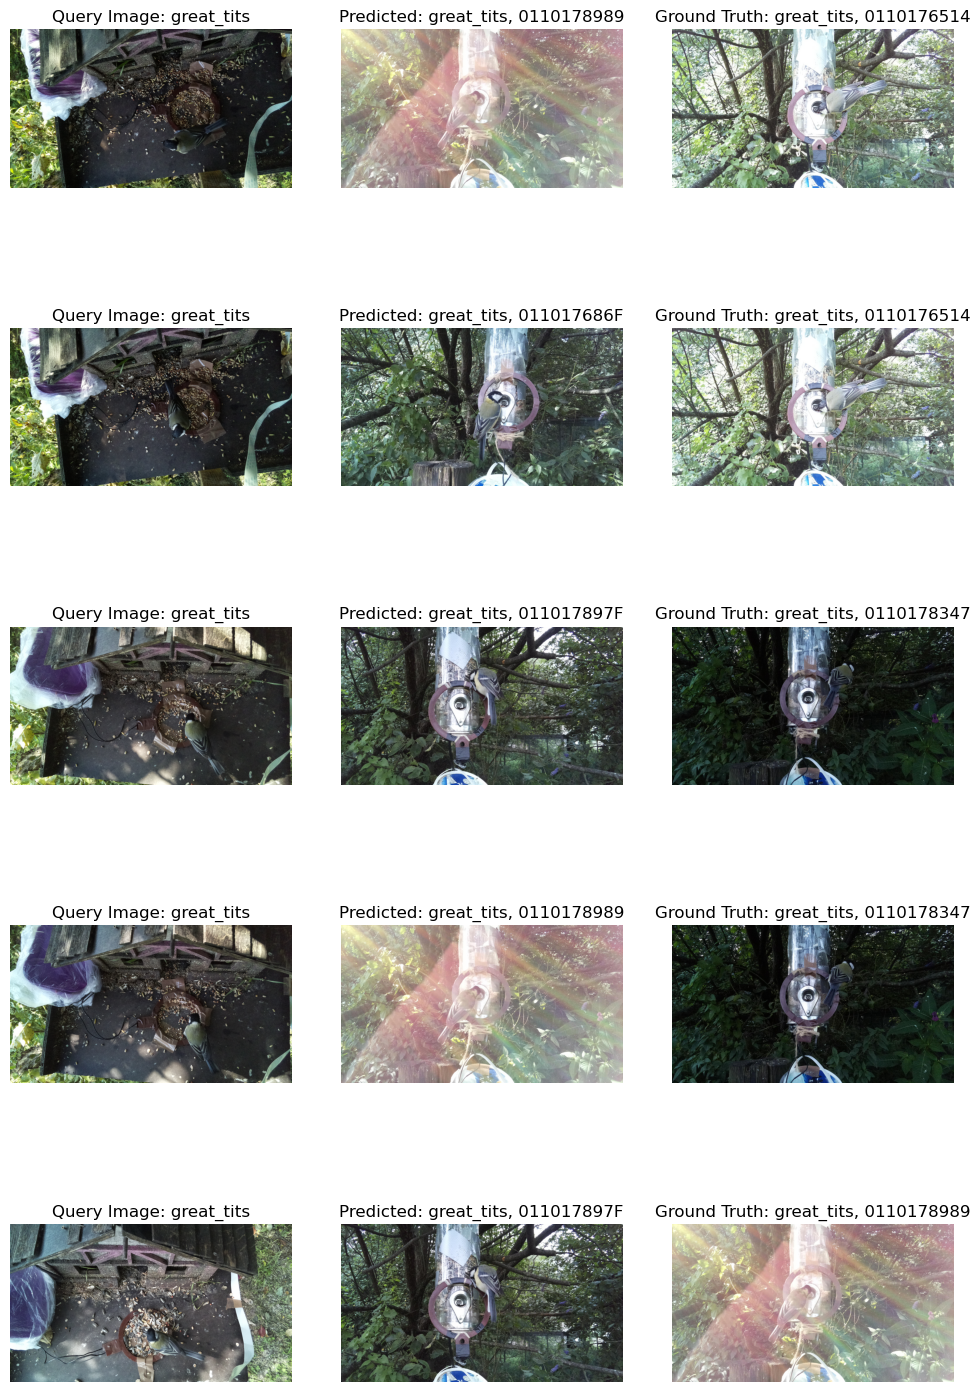

In [116]:
display_results(dataset_query.metadata,dataset_database.metadata, 0, preds, num_images=5)

# Segmentation